In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_experimental as pmx
from pymc_experimental.bart.pgbart import compute_prior_probability

In [3]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [4]:
coal = np.loadtxt("coal.csv")

In [5]:
# discretize data
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

In [6]:
trees = [10, 20, 50, 100, 200]
idatas_coal = {}

In [7]:
for m in trees:
     with pm.Model() as model_coal:
        μ_ = pmx.BART("μ_", X=x_data, Y=y_data, m=m)
        μ = pm.Deterministic("μ", np.abs(μ_))
        y_pred = pm.Poisson("y_pred", mu=μ, observed=y_data)
        idata = pm.sample(chains=4, random_seed=RANDOM_SEED)
        idatas_coal[str(m)] = idata

Multiprocess sampling (4 chains in 3 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Multiprocess sampling (4 chains in 3 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Multiprocess sampling (4 chains in 3 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 105 seconds.
Multiprocess sampling (4 chains in 3 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 209 seconds.
Multiprocess sampling (4 chains in 3 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 417 seconds.


In [8]:
model_compare = az.compare(
    {
        "m10": idatas_coal["10"],
        "m20": idatas_coal["20"],
        "m50": idatas_coal["50"],
        "m100": idatas_coal["100"],
        "m200": idatas_coal["200"]
    }
)


In [9]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m200,0,-31.319546,1.468455,0.000000,1.000000e+00,2.969724,0.000000,False,log
m100,1,-31.394346,1.655521,0.074799,0.000000e+00,3.008190,0.205777,False,log
m50,2,-31.559388,1.664606,0.239841,0.000000e+00,2.998025,0.174311,False,log
m20,3,-31.650890,1.702993,0.331343,0.000000e+00,2.986423,0.266776,False,log
m10,4,-32.206780,1.809690,0.887234,3.330669e-15,2.912630,0.196605,False,log


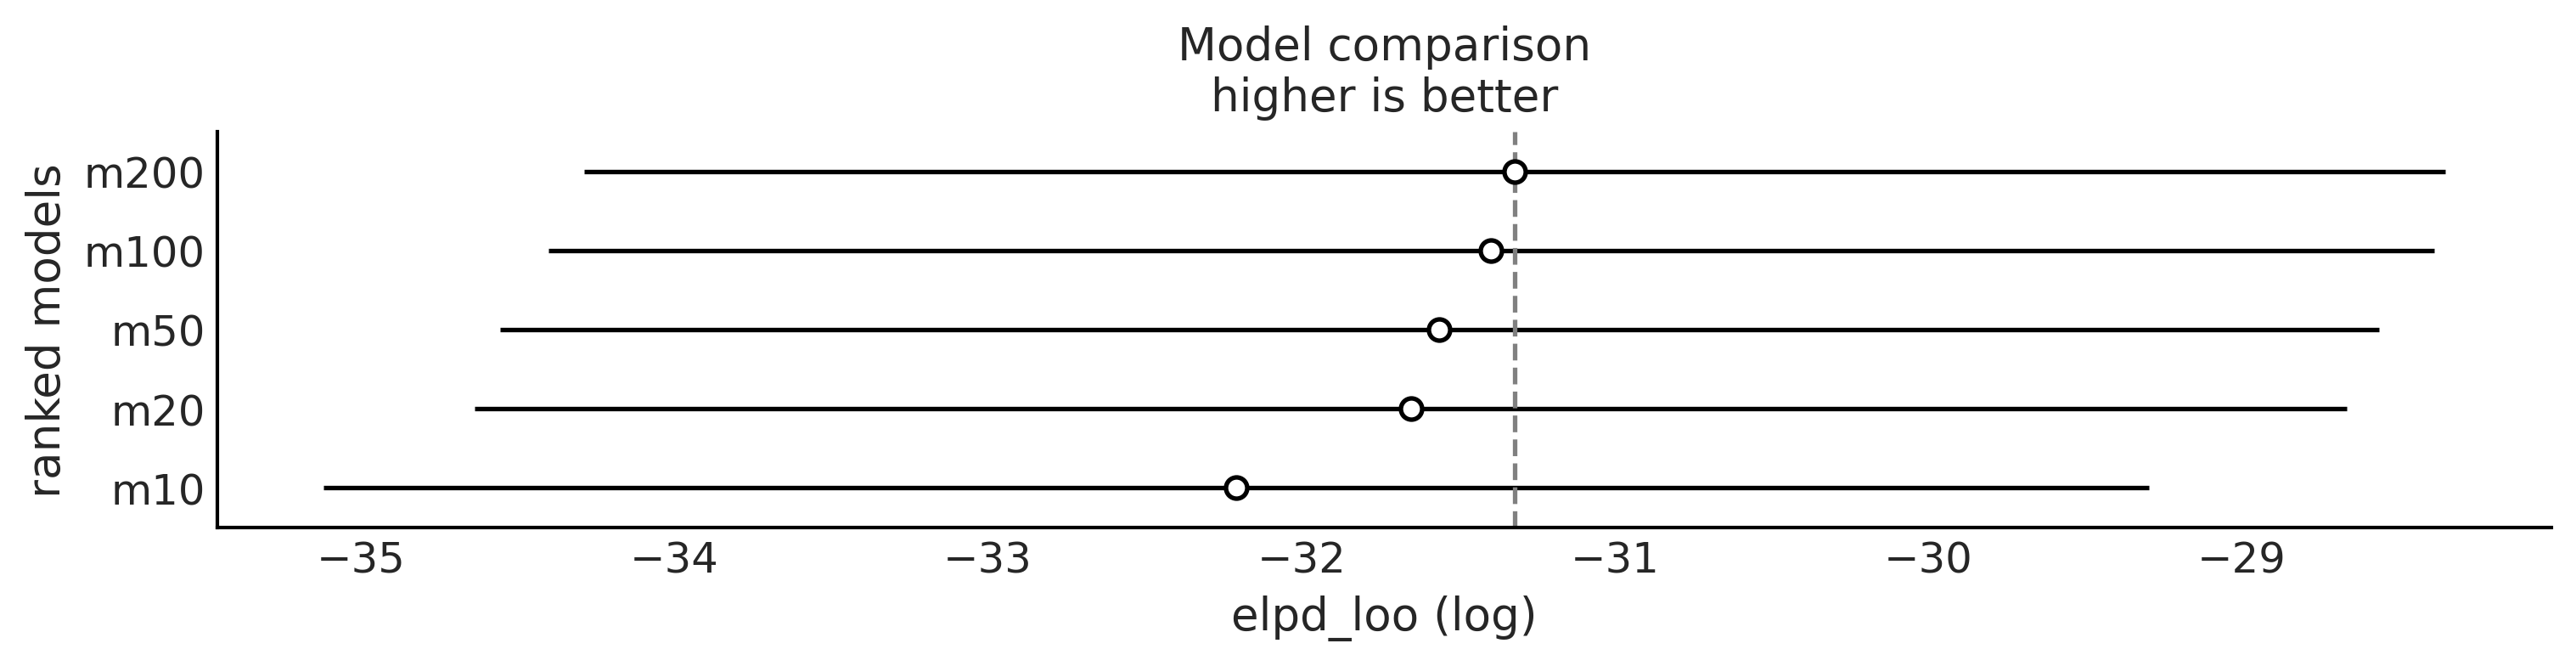

In [10]:
az.plot_compare(model_compare, plot_ic_diff=False, legend=False, figsize=(10, 2.5))
plt.savefig('loo_coal-trees.png')

## Tree extraction

In [11]:
trees_length = {}

In [12]:
for m in trees:
    tmp_list = []
    idata = idatas_coal[f"{m}"].sample_stats.bart_trees
    for chain in idata:
        for sample in chain:
            for tree in sample:
                index = max(tree.item().tree_structure.keys()) 
                tmp_list.append(pmx.bart.tree.BaseNode(index).depth) 
    trees_length[f"{m}"]= pd.Series(tmp_list)

In [13]:
q = compute_prior_probability(0.25)
p = 1 - np.array(q)
p = p / p.sum()

In [14]:
colors = ["C0", "C1", "C2", "C3" ,"C4"]
wd = 0.2
wd_lst = [0, wd, wd*2, wd*3, wd*4]

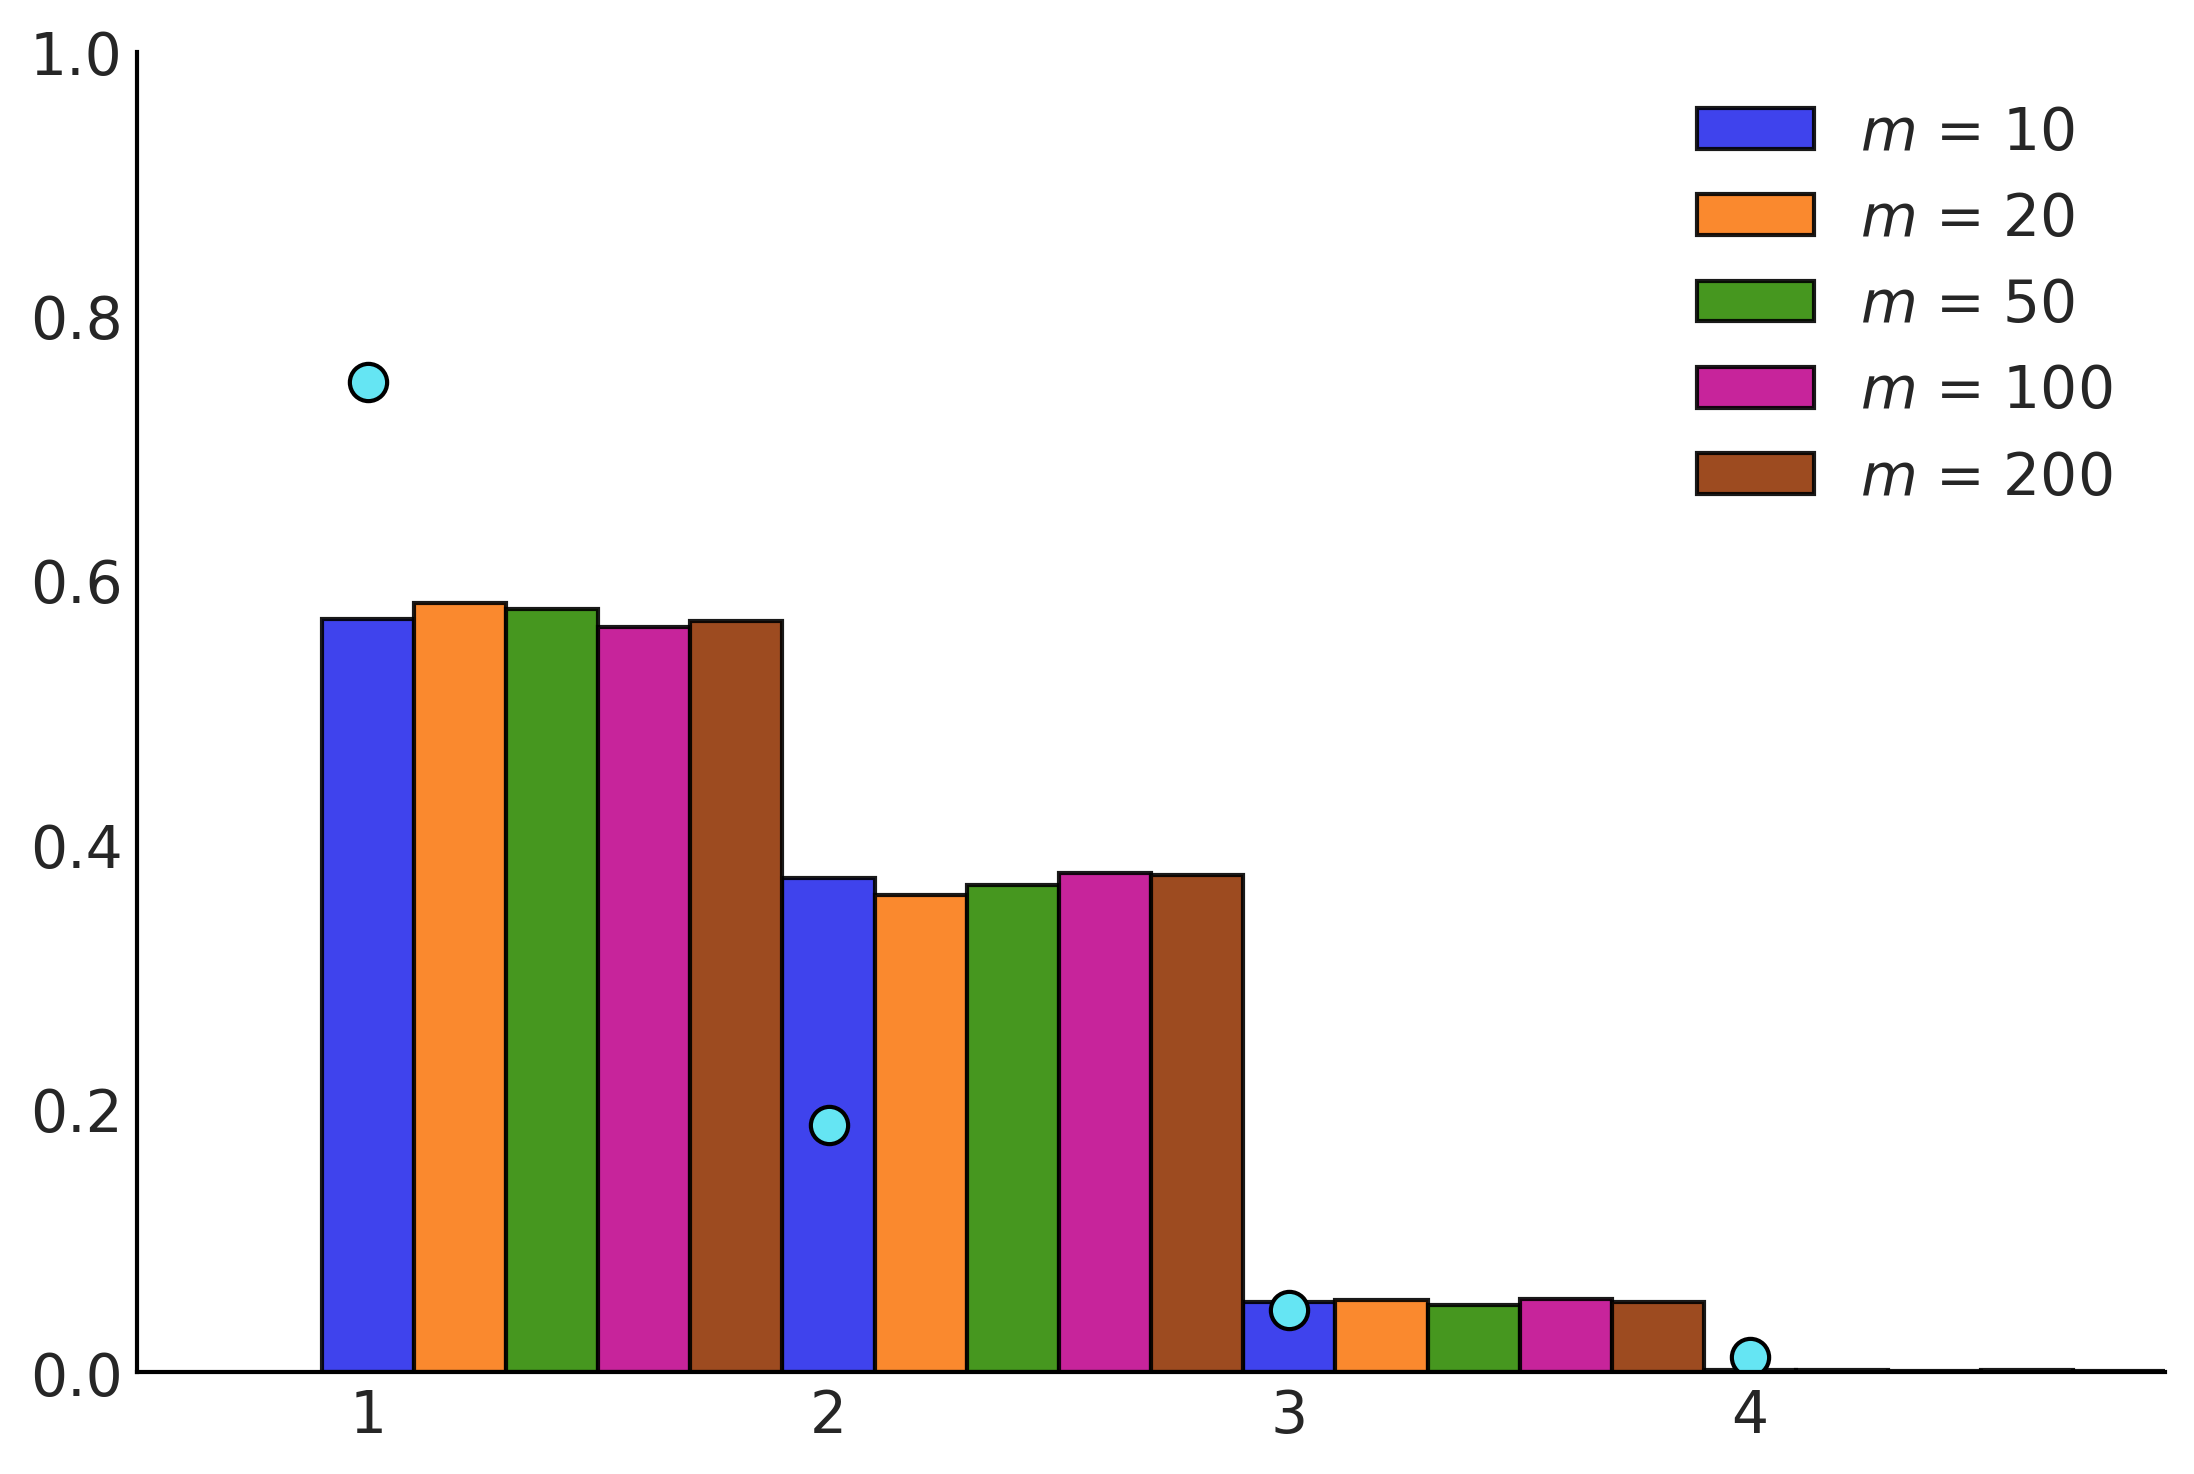

In [17]:
fig = plt.figure()
for i in range(0, len(trees)):
    # Tree Depth Frequency
    frequency = trees_length[f"{trees[i]}"].value_counts(normalize=True).sort_index(ascending=True)
    plt.bar(frequency.index+wd_lst[i], frequency.values,
            color=colors[i], width=wd,
            edgecolor="k", alpha=0.9,
            label=fr"$m$ = {trees[i]}")

# Probabilities
x = np.array(range(1, len(p)+1))
plt.scatter(x, p,
            facecolor="C5",
            edgecolor="k", marker="o",
            s=80, zorder=2)

major_ticks = np.arange(0, 7, 1)
plt.xticks(major_ticks)
plt.ylim(0, 1)
plt.xlim(0.5, 4.9)
plt.legend()


plt.savefig("coal_hist_m.png")